## **RADI622: Medical Image Processing**

### Assignment: Fourier Transform, Image Registration, Image Segmentation, and Morphological Image Processing
**Romen Samuel Rodis Wabina** <br>
Student, PhD Data Science in Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine (Ramathibodi Hospital) <br>
Mahidol University

Note: In case of Python Markdown errors, you may access the assignment through this GitHub [Link](https://github.com/rrwabina/RADI622/blob/main/src/RADI622%20Image%20Processing%20Assignment.ipynb)

In [2]:
import os
import zipfile
import gzip
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
from PIL import Image
import scipy.stats as scs
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import cv2 
from matplotlib.image import imread
from skimage.color import rgb2lab, lab2rgb
from skimage.util import invert
import tensorflow as tf
import warnings 
warnings.filterwarnings('ignore')

from skimage.filters import threshold_otsu

#### Question 1. Suppose we have an EEG signal. We want to analyze the alpha wave (8-12Hz) of the EEG. What is the most reasonable answer that will not destroy the information that we want?
Answer: C. Sampling the signal every 0.05 second

To determine the sampling rate, we can take the reciprocal of the time interval between samples. The reciprocal of 0.05 seconds is 1 / 0.05 = 20 Hz. While this sampling rate is not exactly 24 Hz, it is closer and can capture frequencies up to half of it, which is 10 Hz. Since the alpha wave frequency range falls within 8-12 Hz, this option is reasonably close to the requirement.

**Proof (by inappropriate generalization)**: We created a code as a proof for our answer. Suppose we define the alpha wave frequency range (8-12 Hz) and the maximum frequency we want to capture. The maximum frequency is the half of the upper limit of the alpha wave frequency range (10 Hz). We then calculated the sampling rate by taking the reciprocal of the time interval between samples (0.05 seconds). After that, we compared the sampling rate with the maximum target frequency (10 Hz) to see if it is sufficient to capture frequencies up to half of the alpha wave frequency range.

In [3]:
min_frequency,  max_frequency = 8, 12
tar_frequency = max_frequency / 2
interval = 0.05  
sampling_rate = 1 / interval

if sampling_rate >= max_frequency:
    print(f'The sampling rate of {sampling_rate:.2f} Hz is sufficient to capture frequencies up to {max_frequency:.2f} Hz.')
else:
    print(f'The sampling rate of {sampling_rate:.2f} Hz is NOT sufficient to capture frequencies up to {max_frequency:.2f} Hz.')

The sampling rate of 20.00 Hz is sufficient to capture frequencies up to 12.00 Hz.


#### Question 2. When we apply fourier transform to the image A we get image B (amplitude of frequency domain). What kind of image B would you expect if we increase the intensity of image A by adding some X value?

Let's recreate the images from the question by generating the corresponding sinusoidal gratings. The gratings contains grayscale values that varies according to the sine function and its is a two-dimensional representation in which the amplitude varies sinusoidally along a certain direction. From the given figure, image B shows the visual representation of image A when applied with Fourier transform. Image B shows an all-black image except for the two points in the middle. To review, the primary parameters that characterize a sinusoidal grating are wavelength, amplitude, orientation, and phase. 

The example below shows a grating generated from a wavelength of 200 and 0 degree angle. By convention, if we double the wavelength, the two dots in the Fourier transform move away from the center. The distance of the dots from the center reprersents the frequency of the sinusoidal grating. In other words, the further the dots are from the center, the higher the frequency they represent. When we apply the Fourier transform to the sinusoidal grating, we obtain its amplitude spectrum in the frequency domain. Suppose we reduce the amplitude of the grating, the contrast between the peak and the trough diminishes. Instead of the peak being white and the trough being black, both the peak and trough become levels of gray. This means that the intensity difference between the light and dark regions of the grating decreases, leading to a decrease in the amplitude of the corresponding spatial frequency component in the frequency domain. On one hand, the entire grating becomes uniform if the amplitude is reduced to 0. In this case, there is no distinction between the peak and the trough, and the entire image has the same gray level. When we apply the Fourier transform to this uniform image, the amplitude spectrum will show minimal or no contribution from any specific spatial frequency component since the original grating's pattern has been eliminated.

<Figure size 432x288 with 0 Axes>

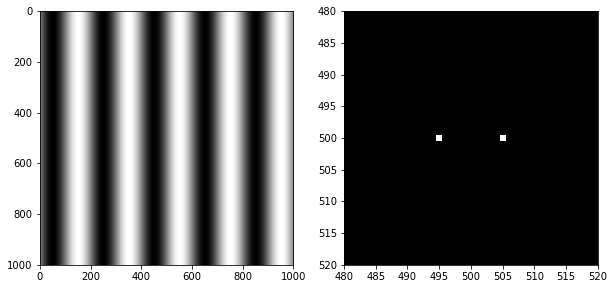

In [4]:
x = np.arange(-500, 501, 1)
X, Y = np.meshgrid(x, x)

wavelength, angle = 200, 0
grating = np.sin(2*np.pi*(X*np.cos(angle) + Y*np.sin(angle)) / wavelength)

plt.set_cmap('gray')
plt.figure(figsize = (10, 5))
plt.subplot(121)
plt.imshow(grating)
ft = np.fft.ifftshift(grating)
ft = np.fft.fft2(ft)
ft = np.fft.fftshift(ft)

plt.subplot(122)
plt.imshow(abs(ft))
plt.xlim([480, 520])
plt.ylim([520, 480])  
plt.show()

#### Question 3. We want to apply a moving average filter (boxcar filter) to our one-dimensional data. The data can be represented by $A(t)$ for $t$ is time in second and $A(t)$ is the amplitude of the data at time $t$.
- Suppose that phase information in our data is very important (phase should not change when doing some processing), what should be our concern when applying a moving average filter?.

The moving average filter is sensitive to the value of the window size $T$ where $T$ determines the number of data points that are averaged together. It directly influences the cutoff frequency of the filter $\frac{1}{T}$ which determines the frequency beyond which the filter begins attenuating the higher-frequency components. A larger $T$ results in a lower cutoff frequency, leading to strong attenuation (reduction or weakening of a signal's intensity as it undergoes processing) of high-frequency components and more aggressive low-pass filtering. Moving average inherently generates constant phase shifts across all frequency components of the signal. This provides time delay (or signal lag) due to the temporal averaging operation and can cause distortion in the temporal alignment of the signal's frequency components. 

Suppose that the phase information is significant and we want to avoid any changes to the phase, we should choose a window size $T$ that corresponds to a zero-phase filter that has a constant phase response across all frequences. In other words, the phase response is flat across all frequencies and the moving average filter maintains the temporal alignment of the input signal's frequency components, making it ideal for preserving phase information. To preserve phase information in our signal data, we can make the window size $T$ an odd number. This ensures that the center of the window aligns with a data point in the original signal. This alignment preserves the phase information at the center of the window, resulting in zero phase shift at that point.


- Show how the information in the frequency domain of our original data will be changed after applying a moving average filter.

The frequency domain using moving average will be changed based on window size $T$. Since the moving average filter serves as a low-pass filter, the original signal attenuates higher-frequency components in the signal. As mentioned previously, the larger window size $T$, the lower cutoff frequency. This criteria implies that frequencies above the cutoff frequency will be more significantly attenuated, leading to a reduction in their amplitudes in the frequency domain. In other words, the moving average filter preserves lower-frequency components of the original signal since frequencies below the cutoff are less affected by the filter and remain unchanged in the frequency domain. Moreover, the moving average translates the signal with a broadening effect. Rapid changes and high-frequency variations in the original signal are smoothed out, leading to a more gradual frequency spectrum in the filtered signal.

We implemented a moving average filter on a given signal in the time domain and then compares the frequency domain representation before and after the filtering process. The moving average is applied to signal $x$ using a window size of 10 samples. 

No handles with labels found to put in legend.


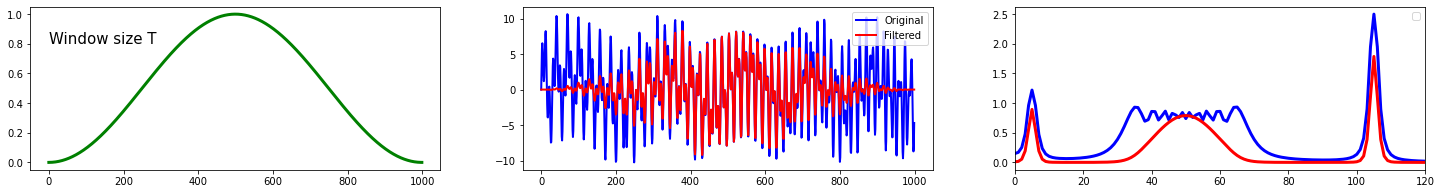

In [5]:
fs = 1000 
t = np.arange(0, 3 + 1/fs, 1/fs)
f = np.linspace(3, 9, num = len(t))

x = 2*np.sin(2 * np.pi * f * t + 0) + 4*np.sin(2 * np.pi * (f+100) * t + 0) + 5*np.sin(2 * np.pi * (f*10) * t + 0)
X = np.fft.fft(x[:1000], axis = -1, n = None)

window_size = 10
filtered_x = np.convolve(x[:1000], np.ones(window_size)/window_size, mode='valid')
X = np.fft.fft(x[:1000], axis=-1, n=None)
X_filtered = np.fft.fft(filtered_x, axis = -1, n = None)
f_bin, t_bin, Zxx = scipy.signal.stft(x = x, fs = fs, nperseg = fs)
fig, ax = plt.subplots(ncols = 3, figsize = (25,3))
ax[0].plot(np.hanning(fs), color = 'green', lw = 3)
ax[0].text(x = 0,y = 0.8, s = 'Window size T', size = 15)

filtered_x = x[:1000] * np.hanning(fs)
ax[1].plot(x[:1000],   label = 'Original', c = 'blue', lw = 2)
ax[1].plot(filtered_x, label = 'Filtered', c = 'red',  lw = 2)
ax[1].legend(loc = 'upper right')

X_filtered = np.fft.fft(filtered_x, axis = -1, n = None)
freq_range = np.fft.fftfreq(1000, d = 1/fs )

ax[2].plot(freq_range[:fs//2],np.abs(Zxx[:500,1]))
ax[2].plot(freq_range[:fs//2],np.abs(X[:fs//2])/(len(x[:1000])/2), lw = 3, c = 'blue')
ax[2].plot(freq_range[:fs//2],np.abs(X_filtered[:fs//2])/(len(x[:1000])/2), alpha = 1, c='red', lw = 3)
ax[2].legend()
ax[2].set_xlim(0, 120)
plt.show()

We also created a side-by-side comparison of the frequency domain representations of the original signal $x$ and the filtered signal using the FFT.

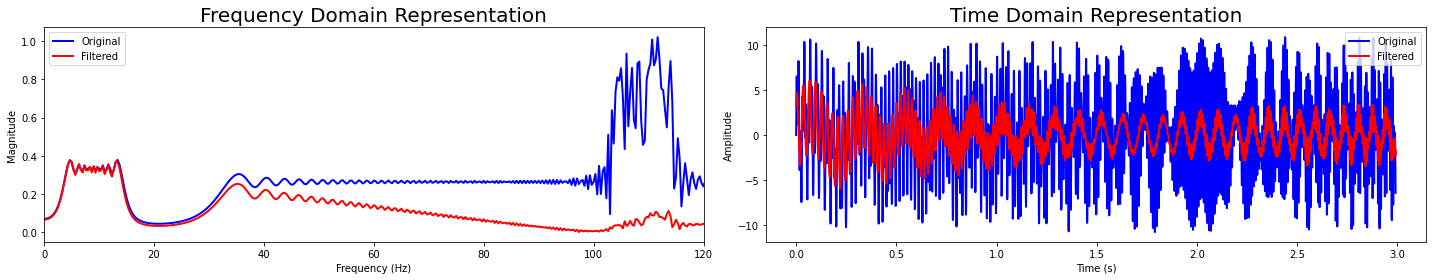

In [16]:
fs = 1000
t = np.arange(0, 3 + 1/fs, 1/fs)
f = np.linspace(3, 9, num=len(t))

x = 2*np.sin(2*np.pi*f*t) + 4*np.sin(2*np.pi*(f+100)*t) + 5*np.sin(2*np.pi*(f*10)*t)

window_size = 10
filtered_x = np.convolve(x, np.ones(window_size)/window_size, mode='valid')

X = np.fft.fft(x, n=None)
X_filtered = np.fft.fft(filtered_x, n=None)
freq_range = np.fft.fftfreq(len(x), d=1/fs)

fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

ax[0].plot(freq_range[:len(x)//2], np.abs(X[:len(x)//2])/(len(x)/2), 
           label = 'Original', lw = 2, c = 'blue')
ax[0].plot(freq_range[:len(x)//2], np.abs(X_filtered[:len(x)//2])/(len(x)/2), 
           label = 'Filtered', lw = 2, c = 'red')
ax[0].set_xlim(0, 120)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Magnitude')
ax[0].set_title('Frequency Domain Representation', size = 20)
ax[0].legend()

ax[1].plot(t[:len(filtered_x)], x[:len(filtered_x)], label='Original', c='blue', lw=2)
ax[1].plot(t[:len(filtered_x)], filtered_x, label='Filtered', c='red', lw=2)
ax[1].legend(loc='upper right')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Time Domain Representation', size = 20)

plt.tight_layout()
plt.show()


#### Question 4. Write simple code for aligning two images (your choice to choose two images freely) using either SimpleITK or SimpleElastix (easier to use than SimpleITK for image registration task) library.
- Align two images using linear transformation 

In [6]:
def threshold_based_crop(image):
    inside_value = 0
    outside_value = 255
    label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
    label_shape_filter.Execute(sitk.OtsuThreshold(image, inside_value, outside_value))

    bounding_box = label_shape_filter.GetBoundingBox(outside_value)
    image = sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2): ], bounding_box[0:int(len(bounding_box)/2)])
    return image

def image_smooth(mri_image):
    return sitk.CurvatureFlow(image1 = mri_image, timeStep = 0.125, numberOfIterations = 3)

def start_plot():
    global metric_values, multires_iterations
    metric_values = []
    multires_iterations = []

def end_plot():
    global metric_values, multires_iterations
    del metric_values
    del multires_iterations
    plt.close()

def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    clear_output(wait=True)
    plt.plot(metric_values, "r")
    plt.plot(
        multires_iterations,
        [metric_values[index] for index in multires_iterations],
        "b*")
    plt.xlabel('Iteration Number', fontsize = 12)
    plt.ylabel('Metric Value',     fontsize = 12)
    plt.show()

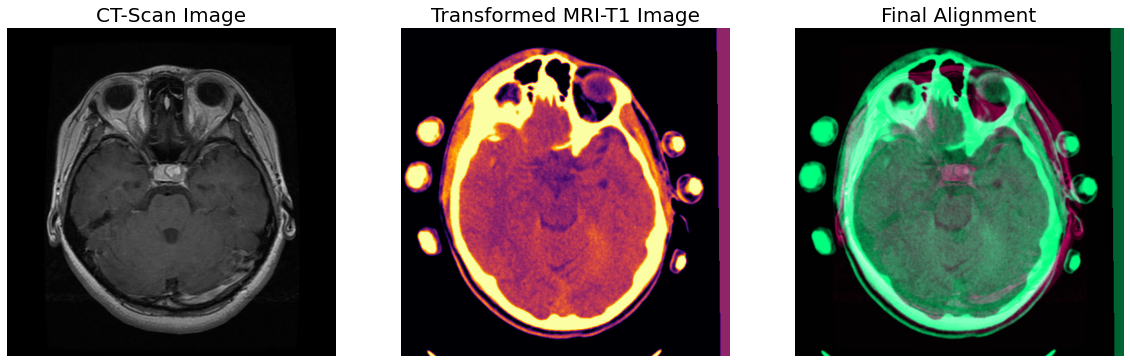

In [17]:
def image_registration(fixed_image_path, moving_image_path):
    ''' 
    Perform image registration to align the moving_image with the fixed_image.

    Parameters:
        fixed_image_path (str): The file path of the fixed image.
        moving_image_path (str): The file path of the moving image.

    Returns:
        fixed_image  (SimpleITK.Image): The fixed image after reading and casting to sitkFloat32.
        moving_image (SimpleITK.Image): The moving image after reading and casting to sitkFloat32.
        final_transform: The transformation that aligns the moving_image to the fixed_image.    
    '''
    fixed_image  = sitk.ReadImage(fixed_image_path,  sitk.sitkFloat32)
    moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

    np.random.seed(2)
    registration_method = sitk.ImageRegistrationMethod()

    initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Similarity2DTransform())

    # We selected Mutual Information as the similarity metric for our registration
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins = 100)

    # We can use a small sample of the image pixels (voxels) to estimate the similarity measure.
    # We initialized a RANDOM sampling such that it draws image pixels (voxels) with replacement 
    # using a uniform distribution, then within each pixel (voxel) randomly perturb from center. 
    # We set SetMetricsamplingPercentage to initialize the pseudorandom number generator's seed.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    # We used linear interpolation with gradient descent as optimizer
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate = 0.001,
                                                      numberOfIterations = 100,
                                                      convergenceMinimumValue = 1e-6,
                                                      convergenceWindowSize   = 10)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    # Set the shrink factors for each level of the multi-resolution pyramid approach.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors     = [4, 2, 1])
    
    # Set the smoothing sigmas for each level of the multi-resolution pyramid approach.
    # Smaller sigmas result in stronger smoothing at each level.
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
    # Indicate that the smoothing sigmas are specified in physical units.
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Execute the registration method using the fixed_image and moving_image after casting them to sitkFloat32.
    # The result will be the final_transform that aligns the moving_image to the fixed_image.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)
    final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32),
                                                  sitk.Cast(moving_image, sitk.sitkFloat32))
    return fixed_image, moving_image, final_transform

def resample_and_compose(fixed_image, moving_image, final_transform):
    ''' 
    Resample and compose the moving_image to align it with the fixed_image using the provided final_transform.

    Parameters:
        fixed_image  (SimpleITK.Image): The reference image to which the moving_image will be aligned.
        moving_image (SimpleITK.Image): The image that needs to be aligned to the fixed_image.
        final_transform: The transformation that aligns the moving_image to the fixed_image.

    Returns:
        cimg (SimpleITK.Image): The composite image, which combines the intensity-scaled fixed_image and the aligned moving_image.
        out (SimpleITK.Image):  The resampled and aligned moving_image after applying the final_transform.

    '''
    resampler = sitk.ResampleImageFilter()
    # Set the reference image (fixed_image) to which the moving_image will be aligned.
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(final_transform)

    out = resampler.Execute(moving_image)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)

    # Create a composite image by combining the scaled fixed_image and the scaled aligned moving_image.
    # The composite image is formed by taking the average of corresponding pixel intensities from both images.
    cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
    return cimg, out


fixed_image_path  = "../data/mri1248.jpg"
moving_image_path = "../data/ct1248.png"

fixed_image, moving_image, final_transform = image_registration(fixed_image_path, moving_image_path)
result_image, resampled = resample_and_compose(fixed_image, moving_image, final_transform)

fixed_image_array  = sitk.GetArrayFromImage(fixed_image)
moving_image_array = sitk.GetArrayFromImage(moving_image)


original_image = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
original_image = sitk.GetArrayFromImage(original_image)
execute = True
if execute:
    plt.figure(figsize=(20,10))
    plt.gray()
    plt.subplot(131), plt.imshow(original_image), plt.axis('off'), plt.title('CT-Scan Image', size = 20)
    plt.subplot(132), plt.imshow(sitk.GetArrayFromImage(resampled),    cmap = 'inferno'),  plt.axis('off'), plt.title('Transformed MRI-T1 Image', size=20)
    plt.subplot(133), plt.imshow(sitk.GetArrayFromImage(result_image), cmap = 'inferno'),  plt.axis('off'), plt.title('Final Alignment', size=20)
    plt.show()

In [15]:
def nonlinear_registration(fixed_image, moving_image, initial_transform=None, use_mattes_mi=False):
    R = sitk.ImageRegistrationMethod()
    if use_mattes_mi:
        R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    else:
        R.SetMetricAsMeanSquares()
    R.SetOptimizerAsRegularStepGradientDescent(4.0, .01, 200)
    R.SetInterpolator(sitk.sitkLinear)

    if initial_transform is None:
        initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler2DTransform())
    R.SetInitialTransform(initial_transform)
    outTx = R.Execute(fixed_image, moving_image)
    return outTx

def resample_and_compose_images(fixed_image, moving_image, transformation):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(transformation)

    output_image = resampler.Execute(moving_image)
    output_array = sitk.GetArrayFromImage(output_image)

    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_image),  sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(output_image), sitk.sitkUInt8)
    composed_image_array = sitk.GetArrayFromImage(sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.))

    return output_array, composed_image_array


fixed_image_path  = '../data/mri1248.jpg'
moving_image_path = '../data/ct1248.png'

fixed_image  = sitk.ReadImage(fixed_image_path,  sitk.sitkFloat32)
moving_image = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

outTx1 = nonlinear_registration(fixed_image, moving_image, use_mattes_mi=False)
outTx2 = nonlinear_registration(fixed_image, moving_image, use_mattes_mi=True)

moving_image_array_trans1, cimg1_array = resample_and_compose_images(fixed_image, moving_image, outTx1)
moving_image_array_trans2, cimg2_array = resample_and_compose_images(fixed_image, moving_image, outTx2)
execute = False
if execute:
    plt.figure(figsize = (15, 20))
    plt.gray()
    plt.subplots_adjust(0,0,1,1,0.075,0.01)
    plt.subplot(321), plt.imshow(fixed_image_array),  plt.axis('off'), plt.title('MR-T1 image', size = 20)
    plt.subplot(322), plt.imshow(moving_image_array), plt.axis('off'), plt.title('CT scan',     size = 20)
    plt.subplot(323), plt.imshow(fixed_image_array - moving_image_array_trans1), plt.axis('off'), plt.title('Difference Images (MeanSquare)', size=20)
    plt.subplot(324), plt.imshow(fixed_image_array - moving_image_array_trans2), plt.axis('off'), plt.title('Difference Images (MutualInformation)', size=20)
    plt.subplot(325), plt.imshow(cimg1_array), plt.axis('off'), plt.title('Aligned Images (MeanSquare)', size=20)
    plt.subplot(326), plt.imshow(cimg2_array), plt.axis('off'), plt.title('Aligned Images (MutualInformation)', size=20)
    plt.show()

- Align two images using nonlinear transformation 

We applied BSpline Transformation as a nonlinear image registration for our MRI-CT images. The BSpline transformations are a type of deformable image registration technique used to align one image to another by modeling local spatial deformations. These deformations are used to describe the local changes in shape and position that occur within specific regions of interest (ROI) in the image. The BSpline transformation estimates how to deform one image to match the other, and it allows for smooth and continuous deformations across the image. 

In our code below, the registration process is performed with the Mattes Mutual Information similarity metric, and the optimization is based on Gradient Descent Line Search. The multi-resolution approach is used with specific shrink factors and smoothing sigmas for each level of the pyramid. 

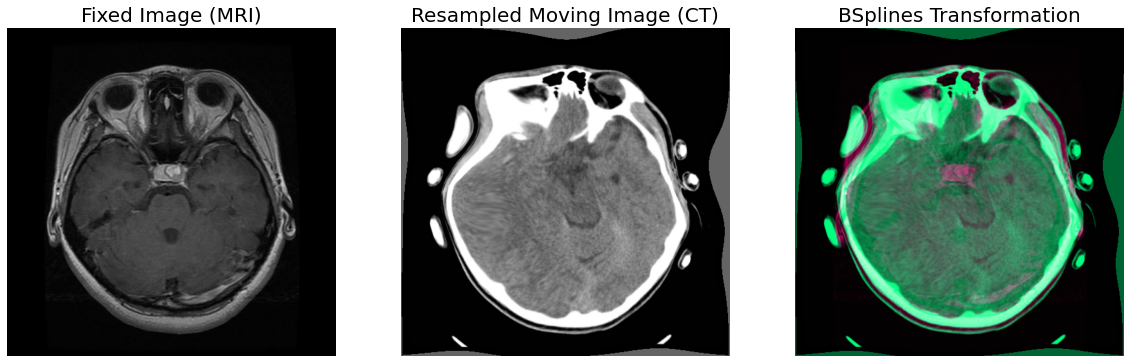

In [42]:
fixed_image_path  = '../data/mri1248.jpg'
moving_image_path = '../data/ct1248.png'
    
fixed  = sitk.ReadImage(fixed_image_path,  sitk.sitkFloat32)
moving = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)

transformDomainMeshSize = [10]*moving.GetDimension()
tx = sitk.BSplineTransformInitializer(fixed,
                                      transformDomainMeshSize)

R = sitk.ImageRegistrationMethod()
R.SetMetricAsMattesMutualInformation(50)
R.SetOptimizerAsGradientDescentLineSearch(0.01, 100,
                                          convergenceMinimumValue = 1e-3,
                                          convergenceWindowSize   = 5)
R.SetOptimizerScalesFromPhysicalShift( )
R.SetInitialTransform(tx)
R.SetInterpolator(sitk.sitkLinear)
R.SetShrinkFactorsPerLevel([6,2,1])
R.SetSmoothingSigmasPerLevel([6,2,1])

outTx = R.Execute(fixed, moving)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(100)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out),   sitk.sitkUInt8)
cimg  = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)

execute = True
if execute:
    plt.figure(figsize=(20,10))
    plt.gray()
    plt.subplot(131), plt.imshow(sitk.GetArrayFromImage(simg1), cmap = 'gray'), plt.axis('off'), plt.title('Fixed Image (MRI)', size = 20)
    plt.subplot(132), plt.imshow(sitk.GetArrayFromImage(simg2), cmap = 'gray'), plt.axis('off'), plt.title('Resampled Moving Image (CT)', size = 20)  
    plt.subplot(133), plt.imshow(sitk.GetArrayFromImage(cimg),  cmap = 'gray'), plt.axis('off'), plt.title('BSplines Transformation', size = 20)  
    plt.show()

#### Question 5. One of the common segmentation method is called GraphCut. (10 points)
- #### Please describe what is graphcut method.

Graphcut is a popular segmentation technique used in computer vision to separate an image into different regions or objects using the concepts of graph theory. Its primary task is to separate the foreground object from the background in an image by partitioning different graph cuts. The Graphcut minimizes an energy function consisting of a data term (i.e., color likelihoods of foreground and background) and a spatial coherency term. The data term involves assessing the color likelihoods of the foreground and background regions, helping determine which pixels are more likely to belong to each region based on their color information. On the other hand, the spatial coherency term is responsible for promoting smoother segmentations by considering both the length of boundaries and the image contrast.

Graphcut is an interactive algorithm where it allows its users to participate in the segmentation process. To do this, the user provides additional information by indicating the regions of interests in the image and marking specific pixels, known as seed points, as part of the foreground or background. Graphcat then uses these sed points as input and guide the segmentation process. The energy function optimizes the seed points as constraints where it ensures that the foreground and background are assigned to the appropriate regions. 

- #### Please explain the process of graphcut, how it works.
The following describes how the Graphcut works as a segmentation problem. Suppose we define a directed graph $G =(V, E)$ where $V, E$ represents the vertices and edges, respectively.

Input: Image $x \in {R, G, B}^{N}$ | Output: Segmentation $S \in R^{N}$

1. The image $x \in {R, G, B}^{N}$ can be represented as a graph $G$ where each pixel are connected by edges $E$ with the adjacent pixels in the image. Every pixel in the image is a vertex $V$ in the graph. A vertex $v \in V$ can be a source vertex $v_s$ that represents the foreground object while the sink vertex $v_t$ corresponds to background object in the image. Hence, $|V(G)| = W \times H + 2$ where $W, H$ represents image width and height, respectively. There are also two types of edges: *n-links* which connect the neighboring pixel within the image and the *t-links* that connect the terminal nodes with the neighborhood nodes. Each edge is assigned with weight $w \in \mathbb{R}^{+}$ that determines the cost. A cut $C$ is a subset of $E$ where the cost of the cut $|C|$ is the sum of the weights on edges C and can be expressed as 
        $$ |C| = \sum_{e \in C}w_e $$
The minimum cut is a cut where $\min(|C|)$ and it can be estimated using the min-cut algorithm. The graph can be divided by this cut and the nodes are separated into two disjoint subsets $S$ and $T$ where $S \cup T = V$. 

2. The primary goal of Graph Cut is to find the maximum amount of flow (i.e., minimum cost) that could be delivered from $v_s$ to $v_t$, while satisfying the following constraints: [1] Each edge $(u, v) \in E$ has nonnegative capacity $c(u, v)$ that must be greater than or equal to its flow; and [2] for all vertices $s, t \in V$, we require that the inflow of the vertex is equal to its outflow. $$ \sum_{v \in V} f(u, v) = \sum_{v \in V} f(u, v) $$

3. The Boykov-Kolmogorov algorithm is an efficient way to compute the min-cut task.

4. For standard Graphcuts, it optimizes the energy function $$ \Phi(X|S) = K^{-\Phi} $$ over the segmentation with some unknown $S$ value and $\Phi$ is the energy function composed of two different models, color and coherence. For iterated Graphcuts: (1) First step optimizes over the color parameters using KMeans; (2) Second step performs the usual graph cuts algorithm

- #### Please explain when to use graphcut and and its advantages and disadvantage.
GraphCut is particularly effective for image segmentation tasks, particularly binary segmentation, where the goal is to partition an image into meaningful regions based on certain criteria (e.g., foreground and background separation). This algorithm can also be applied in interactive segmentation applications where the users can provide initial markers to indicate the foreground and background regions.

The advantages of this algorithm are the following:
- Using cost function 
- Presents a general optimum result for an n-dimensional segmentation if the cost function is clearly described. 
- Graphcut can be utilized with expert opinions since it can be used interactively. This allows the experts or users to guide the segmentation process by providing initial seed points. 
- Graphcut overcomes some of the challenges faced by fully-automatic segmentation methods since it allows users to guide the segmentation process in cases where the algorithm might struggle due to complext shapes and image noise. With Graphcut, it helps to refine the results better based on users' inputs and requirements. 

The disadvantages of this algorithm are the following:
- Graphcuts may exhibit a bias towards generating smaller contours, making it unsuitable for effectively segmenting slender structures like blood vessels due to its goal on finding a minimum cut and cost.
- Graph cuts is restricted to obtaining a global optimum solely for binary labeling tasks, like foreground/background image segmentation. However, there have been suggested enhancements that enable the algorithm to approximate solutions for graph cuts involving multiple labels.

#### Question 6. Given the image of breast cancer provided in the URL, please use Colab to show step-by-step to segment the tumour with traditional image processing techniques. The output should show the colored of the tumour area and its size of the tumour in pixel. Please provide the reasoning in each steps of segmentation. (7 points for reasoning and 3 points for the final output)

We first display the original image and its histogram. The first subplot displays the original image in grayscale, and the second subplot shows the histogram of pixel intensities in the image. The presence of many zeros in the histogram of an image indicates that a significant portion of the image consists of pixels with intensity value 0.

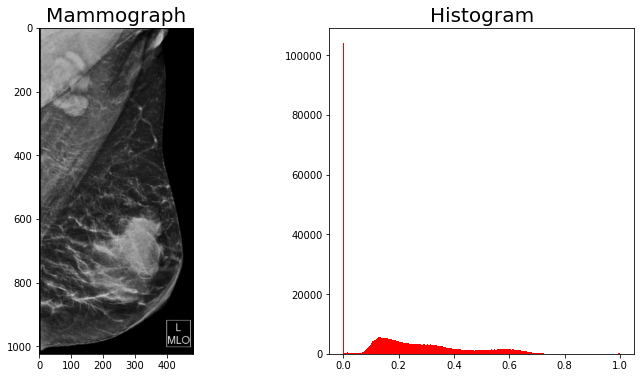

In [16]:
image_path = '../data/breast_cancer_assignment.png'
image = imread(image_path)

def show_result(image, result):
    plt.figure(figsize=(15, 5))
    plt.subplot(121), plt.imshow(image),    plt.axis('off'), plt.title('Original image',    size=20)
    plt.subplot(122), plt.imshow(result),   plt.axis('off'), plt.title('Transformed image', size=20)
    plt.show()


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 6))
ax1.imshow(image, 'gray')
ax2.hist(image.flatten(), 256, color = 'r')
ax1.set_title('Mammograph', size = 20)
ax2.set_title('Histogram',  size = 20)
plt.show()

As a segmentation task, we want to analyze the image and visualize its different color channels (BGR and HSV) individually. We converted the image from the RGB color space to the HSV color space. HSV stands for Hue, Saturation, and Value, and it is a more intuitive color representation compared to RGB. We want to understand the color composition and intensity variations in the given image. By visualizing individual color channels and the value channel, users can gain insights into the image's color information and brightness characteristics.

As you can see from the results, we can visualize a potential type of tumor that is reflected across all channels. 

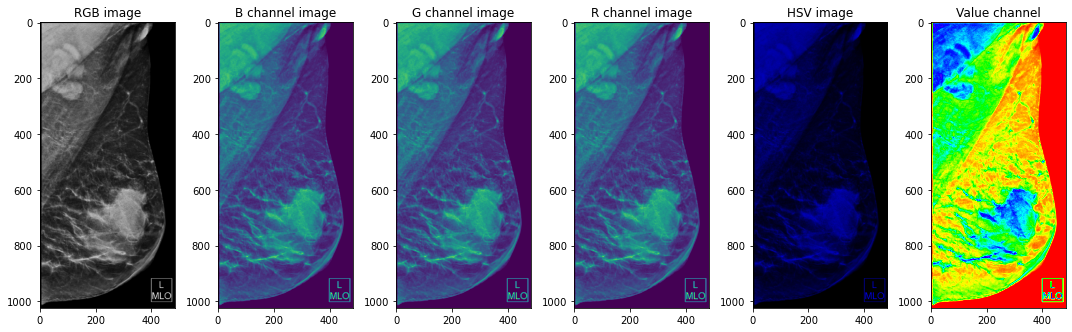

In [25]:
image_path = '../data/breast_cancer_assignment.png'
image = cv2.imread(image_path)

hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #convert RGB channel to HSV channel
h, s, v = cv2.split(hsv_image)    #Splitting the image into HSV channels individually
b, g, r = cv2.split(image)        #Splitting the image into BGR channels individually

fig = plt.figure(figsize = (15, 8))
plt.subplot(1, 6, 1)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.title("RGB image")

plt.subplot(1, 6, 2)
plt.imshow(b)
plt.title("B channel image")

plt.subplot(1, 6, 3)
plt.imshow(g)
plt.title('G channel image')

plt.subplot(1, 6, 4)
plt.imshow(r)
plt.title('R channel image')

plt.subplot(1, 6, 5)
plt.imshow(hsv_image, cmap = 'hsv')
plt.title("HSV image")

plt.subplot(1, 6, 6)
plt.imshow(v, cmap = 'hsv')
plt.title('Value channel')
plt.tight_layout()

We applied different types of filters since tumor segmentation varies and oftern requires a combination of several techniques. Primarily, a medial filter applied to the image is useful for images like our data with a lot of salt-and-pepper noise while preserving the edges. It replaces each pixel's value with the median of its neigboring pixels. 

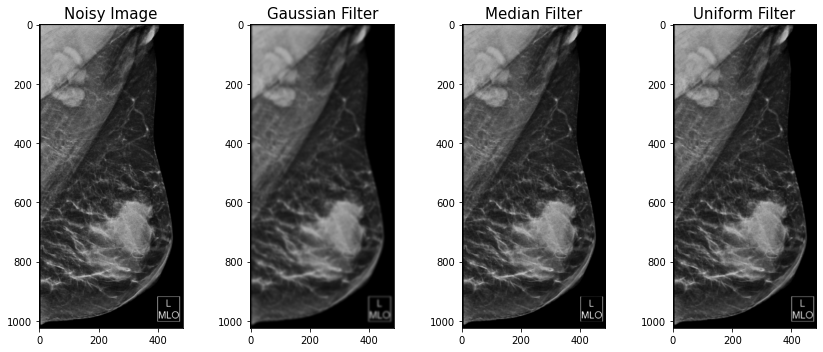

In [17]:
from scipy import ndimage as nd

image = cv2.imread(image_path)
gaussn_image = nd.gaussian_filter(image, sigma = 3)
unifrm_image = nd.uniform_filter(image)
median_image = nd.median_filter(image, size = 3)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize = (12, 5))
ax1.imshow(image, cmap = 'gray')
ax1.set_title('Noisy Image', 
              size = 15)
ax2.imshow(gaussn_image, cmap = 'gray')
ax2.set_title('Gaussian Filter', 
              size = 15)
ax3.imshow(median_image, cmap = 'gray')
ax3.set_title('Median Filter', 
              size = 15)
ax4.imshow(unifrm_image, cmap = 'gray')
ax4.set_title('Uniform Filter', 
              size = 15)

plt.tight_layout()

We used the median-filtered image for our initial thresholding process since unlike linear filters that can blur edges, the median filter preserves edges in the image. Edges represent boundaries between different regions, and preserving them is essential for accurate image segmentation. Otsu thresholding, being a global thresholding method, can be sensitive to noise, and blurring edges can lead to inaccurate segmentation.

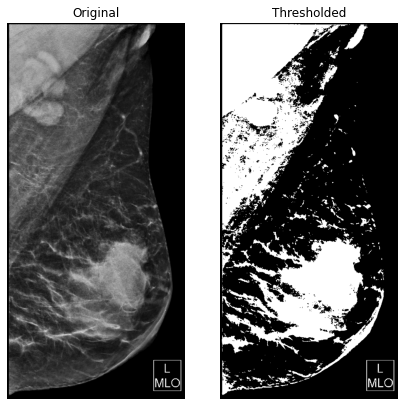

In [20]:
thresh = threshold_otsu(median_image)
binary = median_image > thresh

fig, axes = plt.subplots(ncols = 2, figsize = (7, 10))
ax = axes.ravel()
ax[0] = plt.subplot(1, 2, 1)
ax[0].imshow(image, cmap = plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].imshow(binary, cmap = plt.cm.gray)
ax[1].set_title('Thresholded')
ax[1].axis('off')
plt.show()

In [21]:
def kmeans_segmentation(image, n_clusters):
    '''
    Perform K-means segmentation on the input image.

    Parameters:
        image (numpy.ndarray): The input image (RGB) to be segmented.
        n_clusters (int): The number of clusters or segments desired in the segmented image.

    Returns:
        segmented_image (numpy.ndarray): The segmented image with 'n_clusters' segments.
    '''
    pixels = image.reshape(-1, 3).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixels, n_clusters, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)
    return segmented_image

def gmm_segmentation(image, n_clusters):
    ''' 
    Perform Gaussian Mixture Model (GMM) segmentation on the input image.

    Parameters:
        image (numpy.ndarray): The input image (RGB) to be segmented.
        n_clusters (int): The number of clusters or segments desired in the segmented image.

    Returns:
        segmented_image (numpy.ndarray): The segmented image with 'n_clusters' segments.

    '''
    pixels = image.reshape(-1, 3).astype(np.float32)
    em_model = cv2.ml.EM_create()
    em_model.setClustersNumber(n_clusters)
    _, labels, centers = em_model.trainEM(pixels)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image.shape)

    return segmented_image

(-0.5, 483.5, 1023.5, -0.5)

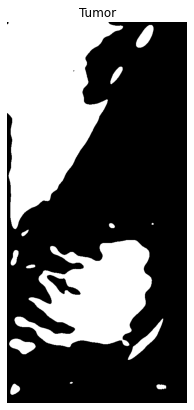

In [37]:
from skimage import measure

image_path = '../data/breast_cancer_assignment.png'
img = cv2.imread(image_path, 0)
img = cv2.GaussianBlur(img,(51, 51), 0) 
ret2, image = cv2.threshold(img, 0, 255, 
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize = (10, 7))
plt.imshow(image, cmap = 'gray')
plt.title('Tumor')
plt.axis('off')

We calculated various region properties for each labeled region. These properties include the centroid, area, bounding box, equivalent diameter, orientation, perimeter, major axis length, and minor axis length.

We then visualized every label based on the corresponding measurement from the region properties. As per the plot below, we are highly interested in label 7 since it is preassumed as the initial tumor. 

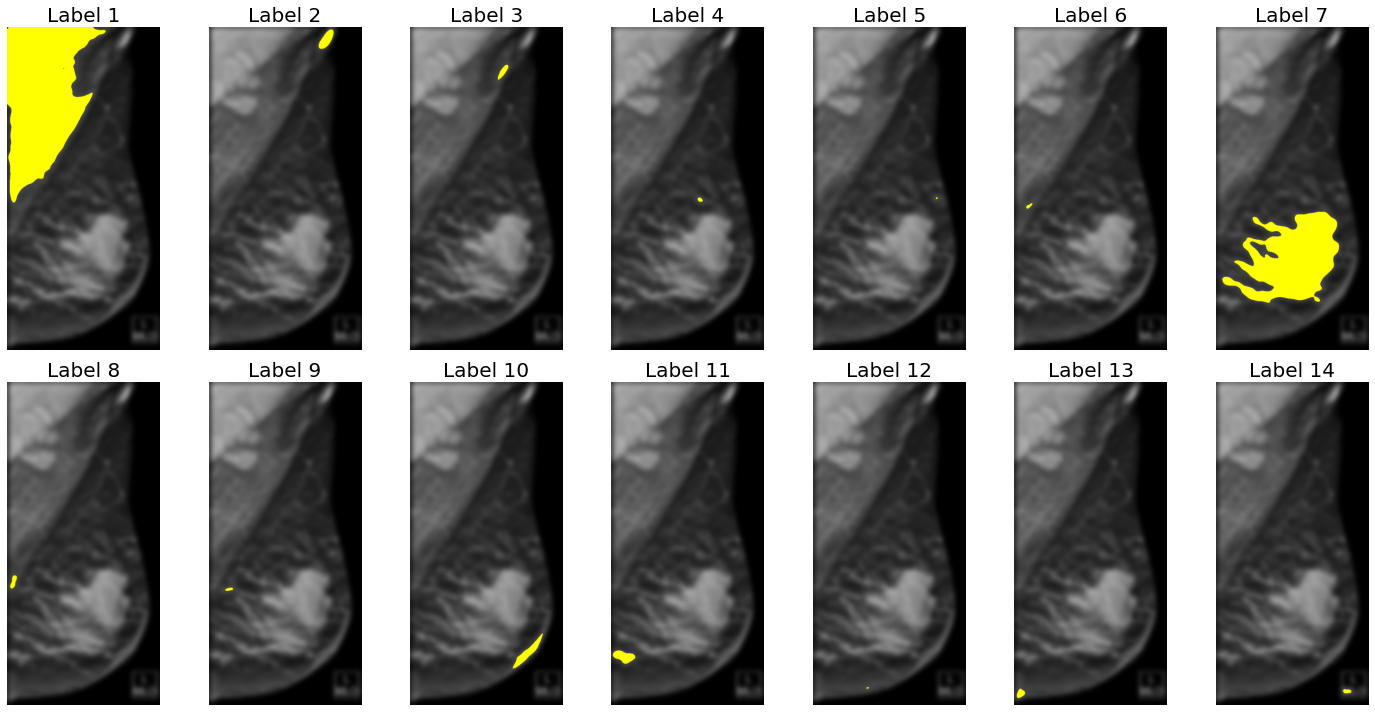

In [54]:
num_labels, labels = cv2.connectedComponents(image)
image_colored = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
properties = measure.regionprops_table(labels, properties = ('label', 'centroid', 'area', 'bbox', 'area', 'centroid', 'equivalent_diameter',
                                                           'orientation', 'perimeter', 'major_axis_length', 'minor_axis_length'))

centroids  = zip(properties['centroid-0'], properties['centroid-1'])

fig, axs = plt.subplots(2, 7, figsize=(20, 10))
for label in range(1, 15):
    image_np = np.array(img)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    image_np[labels == label] = [255, 255, 0]
    row_idx = (label - 1) // 7
    col_idx = (label - 1) % 7
    axs[row_idx, col_idx].imshow(image_np)
    axs[row_idx, col_idx].set_title(f'Label {label}', size = 20)
    axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

Label 7 in the segmented image represents a specific region of interest, likely indicating a tumor within the medical image. With an area of 60685 square pixels, this labeled region stands out as a relatively large and significant segment in the image. The centroid of the tumor is located at coordinates (281.397516, 547.105590), which indicates its approximate center within the image. The equivalent diameter of the tumor is calculated as 360.813244 pixels, representing an estimation of its size based on its area. The orientation of the tumor is approximately 0.998778, which might provide insights into its alignment within the image. Additionally, the major axis length and minor axis length are computed as 46.041631 and 17.210738 pixels, respectively, offering information about the tumor's elongation along these axes. 

In [24]:
pd.DataFrame(properties)

,label,centroid-0,centroid-1,area,bbox-0,bbox-1,bbox-2,bbox-3,equivalent_diameter,orientation,perimeter,major_axis_length,minor_axis_length
0,1,221.699750,110.353738,102248,0,0,557,312,360.813244,-0.156805,1735.969696,566.954759,258.138986
1,2,39.246350,370.864964,1644,8,347,69,394,45.751566,-0.582250,171.580736,72.182580,29.185932
2,3,141.544808,293.879090,703,120,278,167,311,29.918011,-0.584409,123.781746,55.063633,16.349245
3,4,547.105590,281.397516,161,540,274,554,290,14.317527,0.998778,46.041631,17.210738,11.925883
4,5,542.166667,391.125000,24,540,389,545,395,5.527906,-1.517191,15.656854,5.811014,5.247635
5,6,567.023669,47.343195,169,558,38,576,58,14.668929,-0.915259,56.769553,24.467654,9.202980
6,7,734.714097,240.092675,60685,586,20,874,390,277.968599,-0.944143,2093.932250,357.986699,250.664923
7,8,633.058271,20.238722,532,613,10,655,31,26.026207,-0.273914,104.426407,46.988356,15.035812
8,9,656.629032,63.526882,186,652,51,662,76,15.389040,-1.392734,57.798990,26.058172,9.116049
9,10,857.991813,371.862874,2443,797,325,908,420,55.772074,-0.759111,312.516811,138.711719,23.977304
